In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import soundfile as sf
import IPython.display as ipd

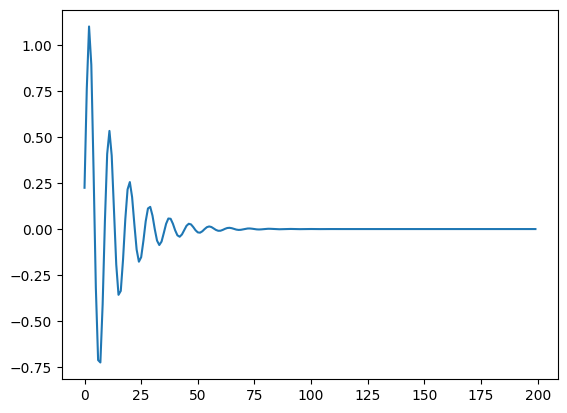

In [2]:
class WahWah(object):
    def __init__(self, fc=500, gain=1.0, q=2.0, lfo_freq=2.5, lfo_depth=100, fs=4410):
        self.fc = fc
        self.gain = gain
        self.q = q
        self.lfo_freq = lfo_freq
        self.lfo_depth = lfo_depth
        self.fs = fs

        self.z1 = 0
        self.z2 = 0
        self.lfo_phi = 0

        self.B, self.A = self.designRLPF(self.fc, self.q, self.gain, self.fs)

    def designRLPF(self, fc, q, gain, fs):
        '''
        Get the digital resonant low pass filter coefficients from
        the analog prototype filter
        '''

        # pre warp
        fc = 2 * fs * np.tan((fc*2*np.pi)/(2*fs))

        # analog filter coefficients
        Bs = np.array([0.0, 0.0, gain])
        As = np.array([1.0/(fc*fc), 1.0/(fc*q), 1.0])

        # get digital coefficients
        Bz, Az = sig.bilinear(Bs, As, fs)

        return Bz, Az

    def process(self, input):
        output = np.zeros(np.size(input))
        two_pi = 2 * np.pi
        for i in np.arange(0, np.size(input), 1):
            # TODO: implement LFO
            # update LFO phase
            self.lfo_phi = (self.lfo_phi + two_pi * (self.lfo_freq / self.fs)) % two_pi # do I need to add prewarping here?

            # cutoff frequency offset is the scaled output of the sine of the new phase
            fc_offset = self.lfo_depth * np.sin(self.lfo_phi)


            # calcualte new filter coefficients
            self.B, self.A = self.designRLPF(self.fc + fc_offset, self.q, self.gain, self.fs)

            # get next output sample
            output[i] = self.z1 + self.B[0]*input[i]
            # update filter state
            self.z1 = self.z2 + self.B[1]*input[i] - self.A[1]*output[i]
            self.z2 = self.B[2]*input[i] - self.A[2]*output[i]
        return output

    def reset(self):
        self.z1 = 0
        self.z2 = 0


# impulse as input for making sure things run
fs = 44100
input = np.zeros(200)
input[0] = 1

# load input audio file
# input, fs = sf.read('audio/gtr.wav')


# instantiate a wahwah effect with the desired parameters
wahwah = WahWah(fc=5000, q=4, gain=2, fs=fs, lfo_freq=1.5, lfo_depth=4000)

# process our imput audio file with the wahwah effect
output = wahwah.process(input)

plt.plot(output)
# ipd.Audio(data=output, rate=fs)

Question 1 (b) Test audio dile with wah-wah filter

In [3]:
from IPython.display import Audio
import librosa
from scipy.io.wavfile import write

from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [14]:
audio_file_path = '/content/drive/MyDrive/DST_SP04/hw2/gtr.wav'

audio, sr = librosa.load(audio_file_path)

print("Original: ")
Audio(audio, rate=sr)

Original: 


In [5]:
audio_filter = WahWah(fc=5000, gain=2.0, q=4.0, lfo_freq=1.5, lfo_depth=4000, fs=44100)
audio_wahwah = audio_filter.process(audio)

In [13]:
print("Audio with Wah-Wah filter 1: ")
Audio(audio_wahwah, rate=sr)

Audio with Wah-Wah filter 1: 


In [ ]:
write('guitar_wahwah_1.wav', sr, audio_wahwah.astype(np.float32))
print("Processed audio has been saved.")

In [10]:
audio_filter_2 = WahWah(fc=1000, gain=6.0, q=2.0, lfo_freq=300, lfo_depth=4000, fs=44100)
audio_wahwah_2 = audio_filter.process(audio)

In [11]:
print("Audio with Wah-Wah filter 2: ")
Audio(audio_wahwah_2, rate=sr)


Audio with Wah-Wah filter 2: 


In [12]:
write('guitar_wahwah_2.wav', sr, audio_wahwah_2.astype(np.float32))
print("Processed audio has been saved.")

Processed audio has been saved.
